<a href="https://colab.research.google.com/github/NzimbaEnvoy/Fraud_Detection-Masters-Project-/blob/main/Healthcare_Fraud_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight
import itertools
import shap


In [ ]:
# Path to the files
base_path = "/content/drive/MyDrive/Thesis Project"

train_path = os.path.join(base_path, "train_data_healthcare.csv")
test_path = os.path.join(base_path, "test_data_healthcare.csv")

# Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head(5)

,Amt_Deductible,AnnualAmtReimb_OP,ClaimAmtReimbursed,AnnualAmtReimb_IP,AnnualAmtDeductible_IP,Flag_Alzheimer,Flag_Heartfailure,Flag_KidneyDisease,Flag_Cancer,Flag_ObstrPulmonary,...,Flag_Diabetes,Flag_IschemicHeart,Flag_Osteoporosis,Flag_rheumatoidarthritis,Flag_stroke,Flag_RenalDisease,Gender,Flag_DOA,PotentialFraud,Claim_Duration
0,-0.286098,-0.436333,-0.245161,-0.449110,-0.478336,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,-0.352512
1,-0.286098,0.335244,-0.242635,-0.449110,-0.478336,0,0,0,1,1,...,0,1,0,0,0,0,1,0,1,-0.352512
2,-0.286098,-0.524298,-0.207280,-0.449110,-0.478336,0,1,0,0,0,...,1,1,0,0,0,0,1,0,1,-0.352512
3,-0.286098,-0.496652,-0.242635,-0.449110,-0.478336,0,1,1,1,1,...,1,1,0,1,1,0,0,0,0,-0.352512
4,-0.286098,0.021084,-0.255262,0.983315,0.414580,0,1,1,0,0,...,1,1,0,0,0,1,0,0,0,-0.352512


In [ ]:
# Separating features and target
X_train = train_df.drop("PotentialFraud", axis=1)
y_train = train_df["PotentialFraud"]
X_test = test_df.drop("PotentialFraud", axis=1)
y_test = test_df["PotentialFraud"]

## CNN BASELINE

In [ ]:
# Reshaping input
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn  = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

#Define CNN model

cnn_baseline = Sequential()
# Block 1
cnn_baseline.add(Conv1D(32, 3, activation='relu', padding='same',
                        input_shape=(X_train_cnn.shape[1], 1)))
cnn_baseline.add(BatchNormalization())
cnn_baseline.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_baseline.add(BatchNormalization())
cnn_baseline.add(MaxPooling1D(pool_size=2))
cnn_baseline.add(Dropout(0.3))

# Block 2
cnn_baseline.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_baseline.add(BatchNormalization())
cnn_baseline.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_baseline.add(BatchNormalization())
cnn_baseline.add(MaxPooling1D(pool_size=2))
cnn_baseline.add(Dropout(0.3))

# Head
cnn_baseline.add(Flatten())
cnn_baseline.add(Dense(64, activation='relu'))
cnn_baseline.add(Dropout(0.4))
cnn_baseline.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiling model
cnn_baseline.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Fitting model
cnn_baseline.fit( X_train_cnn, y_train, epochs=30,batch_size=64, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Predicting & evaluating
y_pred_probs_cnn = cnn_baseline.predict(X_test_cnn).flatten()
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int)

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
roc_cnn = roc_curve(y_test, y_pred_probs_cnn)
auc_cnn = roc_auc_score(y_test, y_pred_probs_cnn)

print("Confusion Matrix:")
print(cm_cnn)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5794 - loss: 0.7246 - precision: 0.3908 - recall: 0.1962 - val_accuracy: 0.6251 - val_loss: 0.6711 - val_precision: 0.5263 - val_recall: 0.0228
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6191 - loss: 0.6737 - precision: 0.4593 - recall: 0.0596 - val_accuracy: 0.6239 - val_loss: 0.6655 - val_precision: 0.4844 - val_recall: 0.0118
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6197 - loss: 0.6679 - precision: 0.5071 - recall: 0.0393 - val_accuracy: 0.6262 - val_loss: 0.6634 - val_precision: 0.5538 - val_recall: 0.0274
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6231 - loss: 0.6650 - precision: 0.5625 - recall: 0.0481 - val_accuracy: 0.6252 - val_loss: 0.6626 - val_precision: 0.5255 - val_recall: 0.0274
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6236 - loss: 0.6652 - precision: 0.5465 - recall: 0.0513 - val_accuracy: 0.6256 - val_loss: 

CNN + SMOTE

In [ ]:
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote_cnn = X_train_smote.values.reshape((X_train_smote.shape[0], X_train_smote.shape[1], 1))


In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Defining model
cnn_smote = Sequential()

# Block 1
cnn_smote.add(Conv1D(32, 3, activation='relu', padding='same',
                     input_shape=(X_train_smote_cnn.shape[1], 1)))
cnn_smote.add(BatchNormalization())
cnn_smote.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_smote.add(BatchNormalization())
cnn_smote.add(MaxPooling1D(pool_size=2))
cnn_smote.add(Dropout(0.3))

# Block 2
cnn_smote.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_smote.add(BatchNormalization())
cnn_smote.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_smote.add(BatchNormalization())
cnn_smote.add(MaxPooling1D(pool_size=2))
cnn_smote.add(Dropout(0.3))

# Dense head
cnn_smote.add(Flatten())
cnn_smote.add(Dense(64, activation='relu'))
cnn_smote.add(Dropout(0.4))
cnn_smote.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling
cnn_smote.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Fitting with early stopping
cnn_smote.fit(
    X_train_smote_cnn,
    y_train_smote,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


# Predicting & evaluation
y_pred_probs_cnn_smote = cnn_smote.predict(X_test_cnn).flatten()
y_pred_cnn_smote = (y_pred_probs_cnn_smote > 0.5).astype(int)

cm_cnn_smote = confusion_matrix(y_test, y_pred_cnn_smote)
roc_cnn_smote = roc_curve(y_test, y_pred_probs_cnn_smote)
auc_cnn_smote = roc_auc_score(y_test, y_pred_probs_cnn_smote)

print("Confusion Matrix (SMOTE):")
print(cm_cnn_smote)

CNN + ADASYN

In [ ]:
adas = ADASYN(random_state=123)
X_train_adas, y_train_adas = adas.fit_resample(X_train, y_train)
X_train_adas_cnn = X_train_adas.values.reshape((X_train_adas.shape[0], X_train_adas.shape[1], 1))


In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Defining model
cnn_adas = Sequential()

# Block 1
cnn_adas.add(Conv1D(32, 3, activation='relu', padding='same',
                    input_shape=(X_train_adas_cnn.shape[1], 1)))
cnn_adas.add(BatchNormalization())
cnn_adas.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_adas.add(BatchNormalization())
cnn_adas.add(MaxPooling1D(pool_size=2))
cnn_adas.add(Dropout(0.3))

# Block 2
cnn_adas.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_adas.add(BatchNormalization())
cnn_adas.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_adas.add(BatchNormalization())
cnn_adas.add(MaxPooling1D(pool_size=2))
cnn_adas.add(Dropout(0.3))

# Head
cnn_adas.add(Flatten())
cnn_adas.add(Dense(64, activation='relu'))
cnn_adas.add(Dropout(0.4))
cnn_adas.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_adas.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                 metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting model with early stopping
cnn_adas.fit(
    X_train_adas_cnn,
    y_train_adas,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluating
y_pred_probs_cnn_adas = cnn_adas.predict(X_test_cnn).flatten()
y_pred_cnn_adas = (y_pred_probs_cnn_adas > 0.5).astype(int)

cm_cnn_adas = confusion_matrix(y_test, y_pred_cnn_adas)
roc_cnn_adas = roc_curve(y_test, y_pred_probs_cnn_adas)
auc_cnn_adas = roc_auc_score(y_test, y_pred_probs_cnn_adas)

print("Confusion Matrix (ADASYN):")
print(cm_cnn_adas)

Cost-sensitive CNN

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model
cnn_cost = Sequential()

# Block 1
cnn_cost.add(Conv1D(32, 3, activation='relu', padding='same',
                    input_shape=(X_train_cnn.shape[1], 1)))
cnn_cost.add(BatchNormalization())
cnn_cost.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_cost.add(BatchNormalization())
cnn_cost.add(MaxPooling1D(pool_size=2))
cnn_cost.add(Dropout(0.3))

# Block 2
cnn_cost.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_cost.add(BatchNormalization())
cnn_cost.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_cost.add(BatchNormalization())
cnn_cost.add(MaxPooling1D(pool_size=2))
cnn_cost.add(Dropout(0.3))

# Dense Head
cnn_cost.add(Flatten())
cnn_cost.add(Dense(64, activation='relu'))
cnn_cost.add(Dropout(0.4))
cnn_cost.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_cost.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                 metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting with early stopping and class weights
cnn_cost.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluating
y_pred_probs_cnn_cost = cnn_cost.predict(X_test_cnn).flatten()
y_pred_cnn_cost = (y_pred_probs_cnn_cost > 0.5).astype(int)

cm_cnn_cost = confusion_matrix(y_test, y_pred_cnn_cost)
roc_cnn_cost = roc_curve(y_test, y_pred_probs_cnn_cost)
auc_cnn_cost = roc_auc_score(y_test, y_pred_probs_cnn_cost)

print("Confusion Matrix (Cost-sensitive):")
print(cm_cnn_cost)

ROC Curve for All CNN Models

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(roc_cnn[0], roc_cnn[1], label='Baseline', linewidth=2)
plt.plot(roc_cnn_smote[0], roc_cnn_smote[1], label='SMOTE', linewidth=2)
plt.plot(roc_cnn_adas[0], roc_cnn_adas[1], label='ADASYN', linewidth=2)
plt.plot(roc_cnn_cost[0], roc_cnn_cost[1], label='Cost-sensitive', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for CNN Models (Healthcare Fraud)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

Metrics Comparison Table for CNN Models

In [ ]:
# Computing metrics
results_cnn_fraud = pd.DataFrame({
    "Method": ["Baseline", "SMOTE", "ADASYN", "Cost-sensitive"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_cnn),
        accuracy_score(y_test, y_pred_cnn_smote),
        accuracy_score(y_test, y_pred_cnn_adas),
        accuracy_score(y_test, y_pred_cnn_cost)
    ],
    "Precision": [
        precision_score(y_test, y_pred_cnn),
        precision_score(y_test, y_pred_cnn_smote),
        precision_score(y_test, y_pred_cnn_adas),
        precision_score(y_test, y_pred_cnn_cost)
    ],
    "Recall": [
        recall_score(y_test, y_pred_cnn),
        recall_score(y_test, y_pred_cnn_smote),
        recall_score(y_test, y_pred_cnn_adas),
        recall_score(y_test, y_pred_cnn_cost)
    ],
    "F1": [
        f1_score(y_test, y_pred_cnn),
        f1_score(y_test, y_pred_cnn_smote),
        f1_score(y_test, y_pred_cnn_adas),
        f1_score(y_test, y_pred_cnn_cost)
    ],
    "AUC": [
        auc_cnn,
        auc_cnn_smote,
        auc_cnn_adas,
        auc_cnn_cost
    ]

})

# Show table
print(results_cnn_fraud)

## LSTM MODEL

LSTM BASELINE MODEL

In [ ]:
# Reshaping input
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm  = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model
lstm_baseline = Sequential()
# Block 1
lstm_baseline.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1),
                       return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
lstm_baseline.add(BatchNormalization())

# Block 2
lstm_baseline.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
lstm_baseline.add(BatchNormalization())

# Block 3
lstm_baseline.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
lstm_baseline.add(BatchNormalization())

# Dense head
lstm_baseline.add(Dense(256, activation='relu'))
lstm_baseline.add(Dropout(0.4))
lstm_baseline.add(Dense(128, activation='relu'))
lstm_baseline.add(Dropout(0.3))
lstm_baseline.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile model
lstm_baseline.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fit model with early stopping
lstm_baseline.fit(
    X_train_lstm,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluating
y_pred_probs_lstm = lstm_baseline.predict(X_test_lstm).flatten()
y_pred_lstm = (y_pred_probs_lstm > 0.5).astype(int)

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
roc_lstm = roc_curve(y_test, y_pred_probs_lstm)
auc_lstm = roc_auc_score(y_test, y_pred_probs_lstm)

print("Confusion Matrix (LSTM Baseline):")
print(cm_lstm)

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6055 - loss: 0.6836 - precision: 0.4162 - recall: 0.0928 - val_accuracy: 0.6249 - val_loss: 0.6604 - val_precision: 0.5225 - val_recall: 0.0220
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6231 - loss: 0.6645 - precision: 0.4634 - recall: 0.0431 - val_accuracy: 0.6248 - val_loss: 0.6600 - val_precision: 0.5286 - val_recall: 0.0141
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6208 - loss: 0.6649 - precision: 0.4831 - recall: 0.0329 - val_accuracy: 0.6241 - val_loss: 0.6614 - val_precision: 0.4706 - val_recall: 0.0030
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6198 - loss: 0.6636 - precision: 0.5383 - recall: 0.0584 - val_accuracy: 0.5725 - val_loss: 0.6974 - val_precision: 0.4134 - val_recall: 0.3284
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6263 - loss: 0.6602 - precision: 0.5548 - recall: 0.0714 - val_accuracy: 0.6248 - val

SHAP ANALYSIS

In [ ]:
#Feature Names
feature_names = X_train.columns.tolist()

#Sample Background & Test Data
background_lstm = X_train_lstm[np.random.choice(X_train_lstm.shape[0], 100, replace=False)]
X_explain_lstm = X_test_lstm[np.random.choice(X_test_lstm.shape[0], 50, replace=False)]

#Flatten for KernelExplainer
background_lstm_flat = background_lstm.reshape(background_lstm.shape[0], -1)
X_explain_lstm_flat = X_explain_lstm.reshape(X_explain_lstm.shape[0], -1)

#Define Wrapper Function
def lstm_predict(x_flat):
    x_reshaped = x_flat.reshape((-1, X_train_lstm.shape[1], 1))
    return lstm_baseline.predict(x_reshaped).flatten()

#Create SHAP Explainer
explainer_lstm = shap.KernelExplainer(lstm_predict, background_lstm_flat)

#Compute SHAP Values
shap_values_lstm = explainer_lstm.shap_values(X_explain_lstm_flat)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━

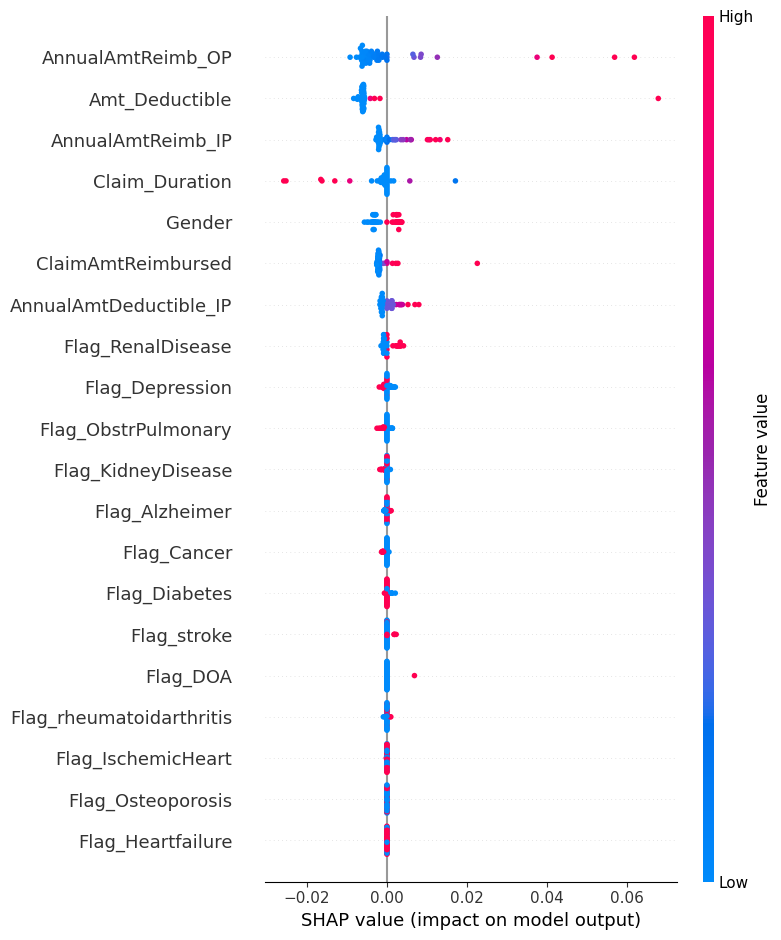

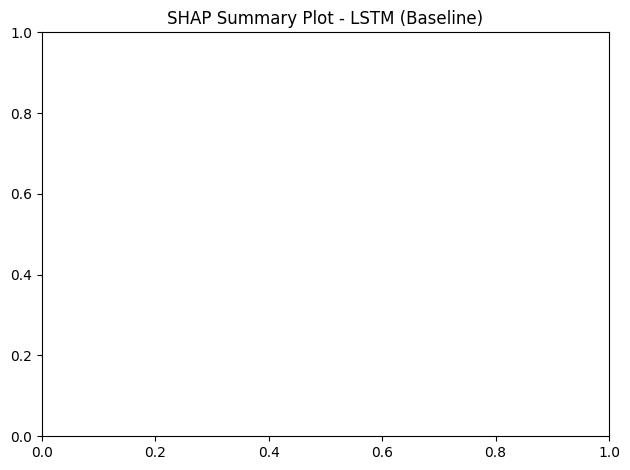

In [ ]:
#SHAP Summary Plot
plt.figure(figsize=(6, 6))
shap.summary_plot(
    shap_values_lstm,
    X_explain_lstm_flat,
    feature_names=feature_names,
    plot_type="dot"
)
plt.title("SHAP Summary Plot - LSTM (Baseline)", fontsize=12)
plt.tight_layout()

LSTM + SMOTE

In [ ]:
X_train_smote_lstm = X_train_smote.values.reshape((X_train_smote.shape[0], X_train_smote.shape[1], 1))


In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model
lstm_smote = Sequential()

# LSTM Block 1
lstm_smote.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1,
                    input_shape=(X_train_smote_lstm.shape[1], 1)))
lstm_smote.add(BatchNormalization())

# LSTM Block 2
lstm_smote.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
lstm_smote.add(BatchNormalization())

# LSTM Block 3
lstm_smote.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
lstm_smote.add(BatchNormalization())

# Dense head
lstm_smote.add(Dense(256, activation='relu'))
lstm_smote.add(Dropout(0.4))
lstm_smote.add(Dense(128, activation='relu'))
lstm_smote.add(Dropout(0.3))
lstm_smote.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compiling model
lstm_smote.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',
                   metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting model with early stopping
lstm_smote.fit(
    X_train_smote_lstm,
    y_train_smote,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluating
y_pred_probs_lstm_smote = lstm_smote.predict(X_test_lstm).flatten()
y_pred_lstm_smote = (y_pred_probs_lstm_smote > 0.5).astype(int)

cm_lstm_smote = confusion_matrix(y_test, y_pred_lstm_smote)
roc_lstm_smote = roc_curve(y_test, y_pred_probs_lstm_smote)
auc_lstm_smote = roc_auc_score(y_test, y_pred_probs_lstm_smote)

print("Confusion Matrix (LSTM + SMOTE):")
print(cm_lstm_smote)

Epoch 1/100
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6059 - loss: 0.6796 - precision: 0.4021 - recall: 0.0784 - val_accuracy: 0.0202 - val_loss: 0.9812 - val_precision: 1.0000 - val_recall: 0.0061
Epoch 2/100
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6258 - loss: 0.6625 - precision: 0.4949 - recall: 0.0370 - val_accuracy: 0.1781 - val_loss: 0.8374 - val_precision: 0.9884 - val_recall: 0.1682
Epoch 3/100
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6207 - loss: 0.6624 - precision: 0.4926 - recall: 0.0442 - val_accuracy: 0.1279 - val_loss: 0.8809 - val_precision: 0.9920 - val_recall: 0.1162
Epoch 4/100
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6309 - loss: 0.6583 - precision: 0.5629 - recall: 0.0767 - val_accuracy: 0.1191 - val_loss: 0.8818 - val_precision: 0.9935 - val_recall: 0.1071
Epoch 5/100
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6277 - loss: 0.6595 - precision: 0.5511 - recall: 0.0602 - val_accura

SHAP ANALYSIS

In [ ]:
#Feature Names
feature_names = X_train.columns.tolist()

#Sample background and test instances
background_smote_lstm = X_train_smote_lstm[np.random.choice(X_train_smote_lstm.shape[0], 100, replace=False)]
X_explain_smote_lstm = X_test_lstm[np.random.choice(X_test_lstm.shape[0], 50, replace=False)]

#Flattening for SHAP KernelExplainer
background_smote_flat = background_smote_lstm.reshape(background_smote_lstm.shape[0], -1)
X_explain_smote_flat = X_explain_smote_lstm.reshape(X_explain_smote_lstm.shape[0], -1)

#Wrapper function for SHAP
def lstm_smote_predict(x_flat):
    x_reshaped = x_flat.reshape((-1, X_train_smote_lstm.shape[1], 1))
    return lstm_smote.predict(x_reshaped).flatten()

#Create SHAP KernelExplainer
explainer_lstm_smote = shap.KernelExplainer(lstm_smote_predict, background_smote_flat)

#Compute SHAP values
shap_values_lstm_smote = explainer_lstm_smote.shap_values(X_explain_smote_flat)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
1/1 ━━━━━━━━━━━

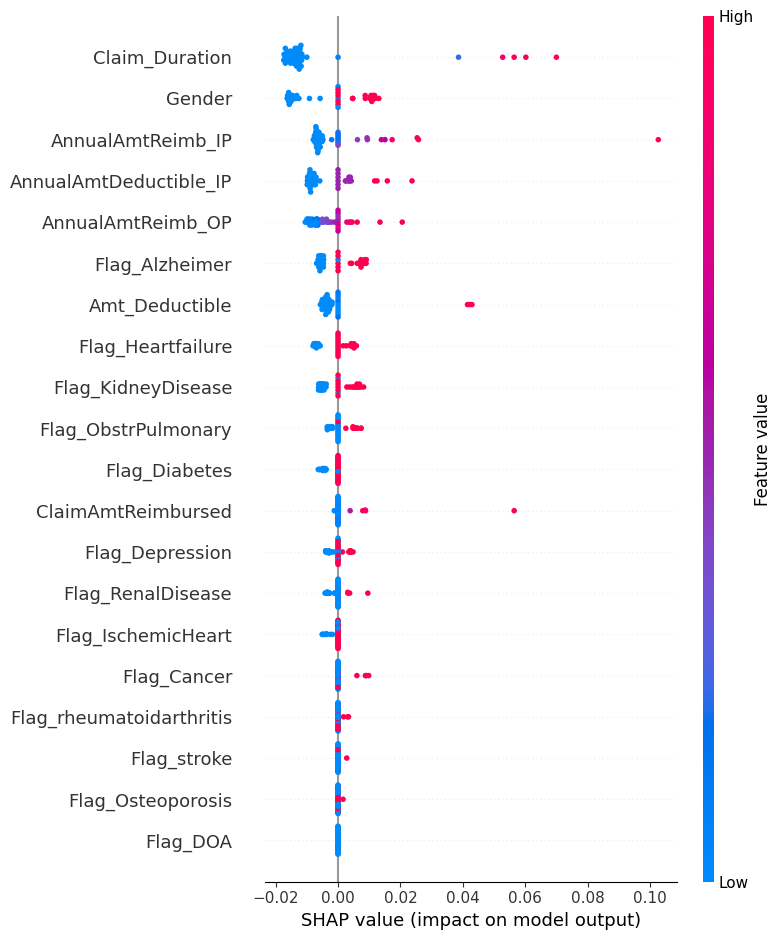

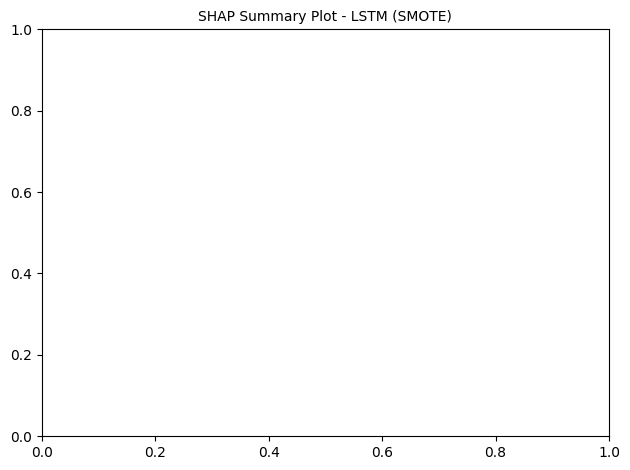

In [ ]:
#SHAP Summary Plot
plt.figure(figsize=(6, 6))
shap.summary_plot(
    shap_values_lstm_smote,
    X_explain_smote_flat,
    feature_names=feature_names,
    plot_type="dot"
)
plt.title("SHAP Summary Plot - LSTM (SMOTE)", fontsize=10)
plt.tight_layout()

LSTM + ADASYN

In [ ]:
X_train_adas_lstm = X_train_adas.values.reshape((X_train_adas.shape[0], X_train_adas.shape[1], 1))


In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model

lstm_adas = Sequential()

# LSTM Block 1
lstm_adas.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1,
                   input_shape=(X_train_adas_lstm.shape[1], 1)))
lstm_adas.add(BatchNormalization())

# LSTM Block 2
lstm_adas.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
lstm_adas.add(BatchNormalization())

# LSTM Block 3
lstm_adas.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
lstm_adas.add(BatchNormalization())

# Dense head
lstm_adas.add(Dense(256, activation='relu'))
lstm_adas.add(Dropout(0.4))
lstm_adas.add(Dense(128, activation='relu'))
lstm_adas.add(Dropout(0.3))
lstm_adas.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compiling model
lstm_adas.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Fitting model with early stopping
lstm_adas.fit(
    X_train_adas_lstm,
    y_train_adas,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluating
y_pred_probs_lstm_adas = lstm_adas.predict(X_test_lstm).flatten()
y_pred_lstm_adas = (y_pred_probs_lstm_adas > 0.5).astype(int)

cm_lstm_adas = confusion_matrix(y_test, y_pred_lstm_adas)
roc_lstm_adas = roc_curve(y_test, y_pred_probs_lstm_adas)
auc_lstm_adas = roc_auc_score(y_test, y_pred_probs_lstm_adas)

print("Confusion Matrix (LSTM + ADASYN):")
print(cm_lstm_adas)

Epoch 1/30
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6032 - loss: 0.6845 - precision: 0.4203 - recall: 0.0966 - val_accuracy: 0.0372 - val_loss: 0.8491 - val_precision: 1.0000 - val_recall: 0.0372
Epoch 2/30
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6196 - loss: 0.6648 - precision: 0.4465 - recall: 0.0324 - val_accuracy: 0.0110 - val_loss: 1.0333 - val_precision: 1.0000 - val_recall: 0.0110
Epoch 3/30
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6227 - loss: 0.6624 - precision: 0.5376 - recall: 0.0407 - val_accuracy: 0.0032 - val_loss: 0.9198 - val_precision: 1.0000 - val_recall: 0.0032
Epoch 4/30
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6209 - loss: 0.6634 - precision: 0.5459 - recall: 0.0529 - val_accuracy: 0.8338 - val_loss: 0.6174 - val_precision: 1.0000 - val_recall: 0.8338
Epoch 5/30
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6225 - loss: 0.6635 - precision: 0.5770 - recall: 0.0729 - val_accuracy: 0

SHAP ANALYSIS

In [ ]:
#Extracting original feature names
feature_names = X_train.columns.tolist()

#Sample background and explanation sets
background_adas_lstm = X_train_adas_lstm[np.random.choice(X_train_adas_lstm.shape[0], 100, replace=False)]
X_explain_adas_lstm = X_test_lstm[np.random.choice(X_test_lstm.shape[0], 50, replace=False)]

#Flatten for KernelExplainer
background_adas_flat = background_adas_lstm.reshape(background_adas_lstm.shape[0], -1)
X_explain_adas_flat = X_explain_adas_lstm.reshape(X_explain_adas_lstm.shape[0], -1)

#Defining model wrapper for SHAP ---
def lstm_adas_predict(x_flat):
    x_reshaped = x_flat.reshape((-1, X_train_adas_lstm.shape[1], 1))
    return lstm_adas.predict(x_reshaped).flatten()

#Creating SHAP KernelExplainer
explainer_lstm_adas = shap.KernelExplainer(lstm_adas_predict, background_adas_flat)

#Compute SHAP values
shap_values_lstm_adas = explainer_lstm_adas.shap_values(X_explain_adas_flat)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━

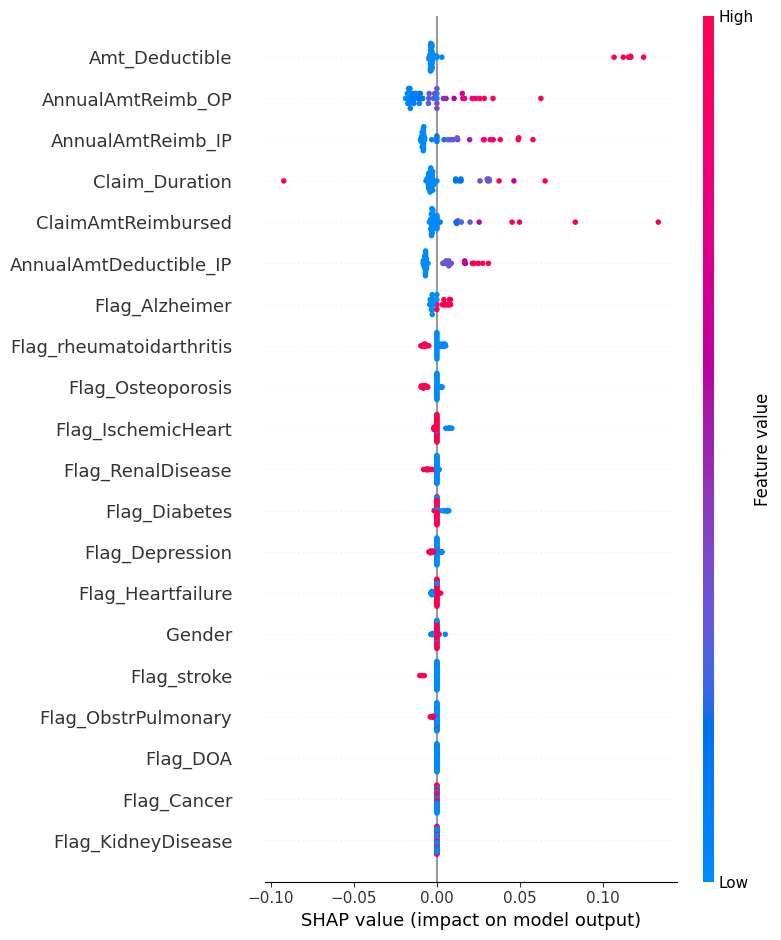

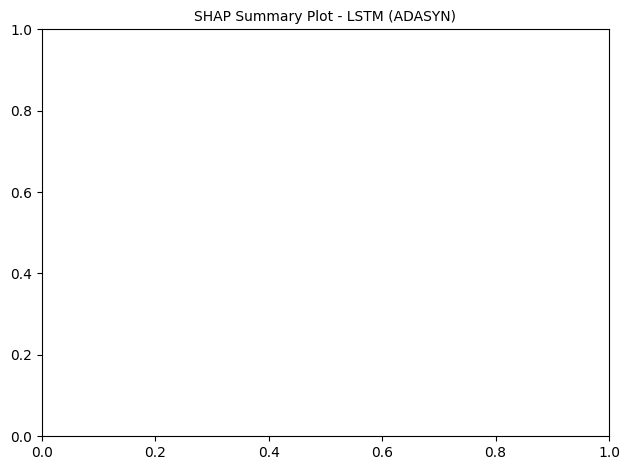

In [ ]:
#SHAP Summary Plot
plt.figure(figsize=(6, 6))
shap.summary_plot(
    shap_values_lstm_adas,
    X_explain_adas_flat,
    feature_names=feature_names,
    plot_type="dot"
)
plt.title("SHAP Summary Plot - LSTM (ADASYN)", fontsize=10)
plt.tight_layout()

Cost-sensitive LSTM

In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model

lstm_cost = Sequential()

# LSTM Block 1
lstm_cost.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1,
                   input_shape=(X_train_lstm.shape[1], 1)))
lstm_cost.add(BatchNormalization())

# LSTM Block 2
lstm_cost.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
lstm_cost.add(BatchNormalization())

# LSTM Block 3
lstm_cost.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
lstm_cost.add(BatchNormalization())

# Dense head
lstm_cost.add(Dense(256, activation='relu'))
lstm_cost.add(Dropout(0.4))
lstm_cost.add(Dense(128, activation='relu'))
lstm_cost.add(Dropout(0.3))
lstm_cost.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compiling model
lstm_cost.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting model with early stopping and class weights
lstm_cost.fit(
    X_train_lstm,
    y_train,
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluation
y_pred_probs_lstm_cost = lstm_cost.predict(X_test_lstm).flatten()
y_pred_lstm_cost = (y_pred_probs_lstm_cost > 0.5).astype(int)

cm_lstm_cost = confusion_matrix(y_test, y_pred_lstm_cost)
roc_lstm_cost = roc_curve(y_test, y_pred_probs_lstm_cost)
auc_lstm_cost = roc_auc_score(y_test, y_pred_probs_lstm_cost)

print("Confusion Matrix (LSTM Cost-sensitive):")
print(cm_lstm_cost)

Epoch 1/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5125 - loss: 0.7068 - precision: 0.3868 - recall: 0.4892 - val_accuracy: 0.5829 - val_loss: 0.6890 - val_precision: 0.4130 - val_recall: 0.2607
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5397 - loss: 0.6937 - precision: 0.4023 - recall: 0.4406 - val_accuracy: 0.5982 - val_loss: 0.6882 - val_precision: 0.4343 - val_recall: 0.2288
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5398 - loss: 0.6924 - precision: 0.4081 - recall: 0.4444 - val_accuracy: 0.3777 - val_loss: 0.7114 - val_precision: 0.3758 - val_recall: 0.9928
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5846 - loss: 0.6891 - precision: 0.4258 - recall: 0.3014 - val_accuracy: 0.4078 - val_loss: 0.7064 - val_precision: 0.3780 - val_recall: 0.8917
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5809 - loss: 0.6879 - precision: 0.4194 - recall: 0.2975 - val_accuracy: 0.5456

In [ ]:
# Saving the trained LSTM model to an HDF5 file
lstm_cost.save("lstm_cost_model.h5")


REALTIME INFERENCE

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

#Loading saved LSTM model
lstm_model = load_model("/content/drive/My Drive/Thesis Project/lstm_cost_model.h5")

X_test_np = X_test.values.astype("float32")
y_test_np = y_test.values.astype("int32")

if X_test_np.ndim == 2:
    X_test_np = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

fraud_idx = np.where(y_test_np == 1)[0]
assert fraud_idx.size > 0, "No fraud rows in test set."
fraud_pool_X = X_test_np[fraud_idx]

#Simulation settings
domain_name  = "healthcare"
lambda_fraud = 4.0667
runs         = 10000
threshold    = 0.50
rng = np.random.default_rng(42)

#Monte Carlo
arrivals_F   = rng.poisson(lam=lambda_fraud, size=runs)
tp_vec       = np.zeros(runs, dtype=int)
det_rate_pct = np.full(runs, np.nan, dtype=float)

for r in range(runs):
    F = arrivals_F[r]
    if F == 0:
        continue
    s_idx = rng.choice(fraud_pool_X.shape[0], size=F, replace=True)
    X_r   = fraud_pool_X[s_idx]

    # Predicting probabilities; assumes model outputs sigmoid probabilities
    p_r  = lstm_model.predict(X_r, verbose=0).reshape(-1)
    yhat = (p_r >= threshold).astype(int)

    TP = int(yhat.sum())
    tp_vec[r]       = TP
    det_rate_pct[r] = 100.0 * TP / F

#Results frame
mc_df = pd.DataFrame({
    "run": np.arange(1, runs+1),
    "fraud_arrivals": arrivals_F,
    "tp": tp_vec,
    "detection_pct": det_rate_pct
})
plot_df = mc_df.dropna(subset=["detection_pct"])




In [ ]:
#Summary table
summary_table = pd.DataFrame([{
    "model": "LSTM (Cost-Sensitive)",
    "threshold": threshold,
    "mean_detection_pct": plot_df["detection_pct"].mean(),
    "median_detection_pct": plot_df["detection_pct"].median(),
    "p05_detection_pct": np.percentile(plot_df["detection_pct"], 5),
    "p95_detection_pct": np.percentile(plot_df["detection_pct"], 95),
    "mean_tp_per_sec": lambda_fraud * plot_df["detection_pct"].mean() / 100.0,
    "p05_tp_per_sec":  lambda_fraud * np.percentile(plot_df["detection_pct"], 5)  / 100.0,
    "p95_tp_per_sec":  lambda_fraud * np.percentile(plot_df["detection_pct"], 95) / 100.0
}])

print(summary_table.to_string(index=False))

                model  threshold  mean_detection_pct  median_detection_pct  p05_detection_pct  p95_detection_pct  mean_tp_per_sec  p05_tp_per_sec  p95_tp_per_sec
LSTM (Cost-Sensitive)        0.5           23.862286                  20.0                0.0          66.666667         0.970408             0.0        2.711133


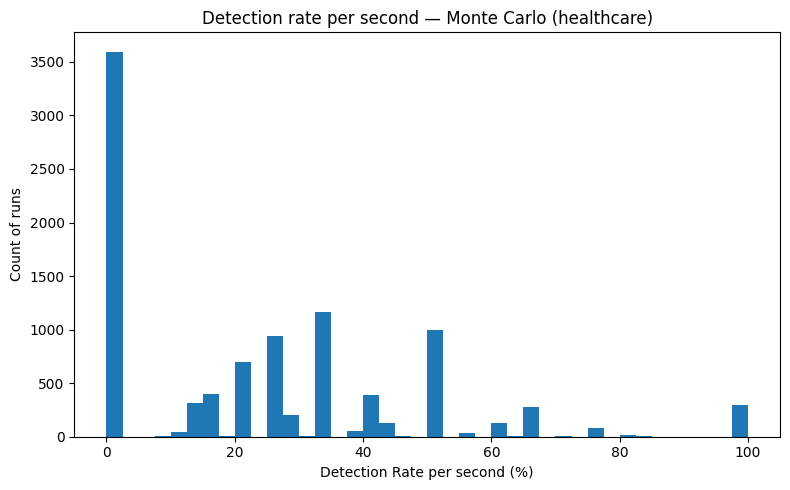

In [ ]:
# Histogram
plt.figure(figsize=(8,5))
plt.hist(plot_df["detection_pct"].values, bins=40)
plt.title(f"Detection rate per second — Monte Carlo ({domain_name})")
plt.xlabel("Detection Rate per second (%)")
plt.ylabel("Count of runs")
plt.tight_layout()
plt.show()

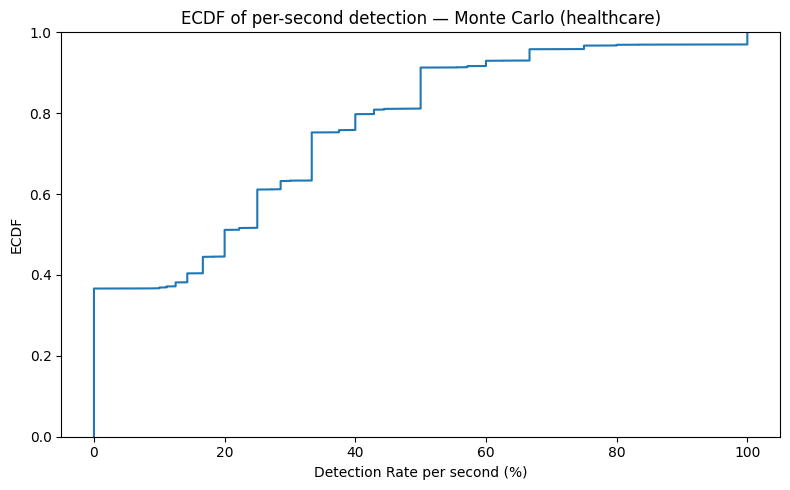

In [ ]:
# ECDF
x = np.sort(plot_df["detection_pct"].values)
y = np.arange(1, x.size+1) / x.size
plt.figure(figsize=(8,5))
plt.plot(x, y)
plt.title(f"ECDF of per-second detection — Monte Carlo ({domain_name})")
plt.xlabel("Detection Rate per second (%)")
plt.ylabel("ECDF")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score


# 1) Loading model + test data
lstm_model = load_model("/content/drive/My Drive/Thesis Project/lstm_cost_model.h5")

X_test_np = X_test.values.astype("float32") if hasattr(X_test, "values") else np.asarray(X_test, dtype="float32")
y_test_np = y_test.values.astype("int32")   if hasattr(y_test, "values") else np.asarray(y_test, dtype="int32")

# labels
assert set(np.unique(y_test_np)).issubset({0, 1}), "y_test must be binary {0,1}"
assert X_test_np.shape[0] == y_test_np.shape[0]

# If LSTM expects
def _ensure_rnn_shape(model, X):
    """
    If model.input_shape is (None, T, C) and X is (n, T), expand to (n, T, 1).
    If already 3D, leave as-is.
    """
    in_shape = model.input_shape
    if X.ndim == 2 and len(in_shape) == 3:
        return np.expand_dims(X, axis=-1)
    return X

X_test_np = _ensure_rnn_shape(lstm_model, X_test_np)

#Simulation settings
lambda_per_sec = 4.0667
runs           = 10000
thr_lstm       = 0.50
rng            = np.random.default_rng(123)

In [ ]:
# Probability helper

def predict_prob_keras(model, X_batch, batch_size=4096):
    """Return p(y=1) for a Keras model (handles (n,1) or (n,) outputs)."""
    p = model.predict(X_batch, batch_size=batch_size, verbose=0)
    return np.asarray(p).reshape(-1)

In [ ]:
#Monte Carlo simulator
def simulate_realtime_fullpool_keras(model, threshold, lambda_rate_per_sec, runs,
                                     X_pool, y_pool, window_secs=1):
    """
    Each run is a window of length `window_secs`.
    arrivals ~ Poisson(lambda_rate_per_sec * window_secs)
    """
    N = X_pool.shape[0]
    arrivals = rng.poisson(lam=lambda_rate_per_sec * window_secs, size=runs)

    TP = np.zeros(runs, dtype=np.int32)
    FP = np.zeros(runs, dtype=np.int32)
    TN = np.zeros(runs, dtype=np.int32)
    FN = np.zeros(runs, dtype=np.int32)

    precision = np.full(runs, np.nan)
    recall    = np.full(runs, np.nan)
    accuracy  = np.full(runs, np.nan)
    f1        = np.full(runs, np.nan)
    auc_vec   = np.full(runs, np.nan)

    for r in range(runs):
        F = arrivals[r]
        if F == 0:
            continue

        idx  = rng.integers(0, N, size=F, dtype=np.int64)
        X_r  = X_pool[idx]
        y_r  = y_pool[idx]
        p_r  = predict_prob_keras(model, X_r)
        yhat = (p_r >= threshold).astype(np.int32)

        tp = np.sum((yhat == 1) & (y_r == 1))
        fp = np.sum((yhat == 1) & (y_r == 0))
        tn = np.sum((yhat == 0) & (y_r == 0))
        fn = np.sum((yhat == 0) & (y_r == 1))

        TP[r], FP[r], TN[r], FN[r] = tp, fp, tn, fn

        if (tp + fp) > 0:
            precision[r] = tp / (tp + fp)
        if (tp + fn) > 0:
            recall[r] = tp / (tp + fn)

        accuracy[r] = (tp + tn) / F
        if not np.isnan(precision[r]) and not np.isnan(recall[r]) and (precision[r] + recall[r]) > 0:
            f1[r] = 2 * precision[r] * recall[r] / (precision[r] + recall[r])

        # AUC only if both classes present in the window
        if (y_r.min() == 0) and (y_r.max() == 1):
            try:
                auc_vec[r] = roc_auc_score(y_r, p_r)
            except Exception:
                pass

    mc_df = pd.DataFrame({
        "run": np.arange(1, runs+1, dtype=np.int32),
        "window_secs": window_secs,
        "arrivals": arrivals,
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "precision": precision, "recall": recall, "accuracy": accuracy, "f1": f1,
        "auc": auc_vec
    })

    summary = {
        "runs": runs,
        "window_secs": window_secs,
        "runs_with_tx": int(np.sum(arrivals > 0)),
        "mean_TP": float(np.nanmean(TP)),
        "mean_FP": float(np.nanmean(FP)),
        "mean_TN": float(np.nanmean(TN)),
        "mean_FN": float(np.nanmean(FN)),
        "mean_precision": float(np.nanmean(precision)),
        "mean_recall": float(np.nanmean(recall)),
        "mean_accuracy": float(np.nanmean(accuracy)),
        "mean_f1": float(np.nanmean(f1)),
        "mean_auc": float(np.nanmean(auc_vec)),
        "median_auc": float(np.nanmedian(auc_vec)),
        "n_auc_runs": int(np.sum(~np.isnan(auc_vec))),
    }
    summary_df = pd.DataFrame([summary])
    return {"mc_df": mc_df, "summary": summary_df}

In [ ]:
#Run LSTM at 1s and 10s windows
res_lstm_1s  = simulate_realtime_fullpool_keras(
    model=lstm_model, threshold=thr_lstm, lambda_rate_per_sec=lambda_per_sec,
    runs=runs, X_pool=X_test_np, y_pool=y_test_np, window_secs=1
)
res_lstm_10s = simulate_realtime_fullpool_keras(
    model=lstm_model, threshold=thr_lstm, lambda_rate_per_sec=lambda_per_sec,
    runs=runs, X_pool=X_test_np, y_pool=y_test_np, window_secs=10
)

In [ ]:
#Compare summaries
summary_table = pd.concat([
    res_lstm_1s["summary"].assign(model="LSTM (Healthcare)", time_unit="1 sec",  threshold=thr_lstm),
    res_lstm_10s["summary"].assign(model="LSTM (Healthcare)", time_unit="10 sec", threshold=thr_lstm),
], ignore_index=True)[[
    "model","time_unit",
    "mean_accuracy","mean_precision","mean_recall","mean_f1",
    "mean_auc"
]]

print(summary_table.to_string(index=False))

            model time_unit  mean_accuracy  mean_precision  mean_recall  mean_f1  mean_auc
LSTM (Healthcare)     1 sec       0.598555        0.441893     0.235225 0.645246  0.527959
LSTM (Healthcare)    10 sec       0.596946        0.438478     0.234598 0.304509  0.529425


SHAP ANALYSIS

In [ ]:
#Extract original feature names
feature_names = X_train.columns.tolist()

#Sample background and explanation sets
background_lstm_cost = X_train_lstm[np.random.choice(X_train_lstm.shape[0], 100, replace=False)]
X_explain_lstm_cost = X_test_lstm[np.random.choice(X_test_lstm.shape[0], 50, replace=False)]

#Flattening for KernelExplainer
background_lstm_cost_flat = background_lstm_cost.reshape(background_lstm_cost.shape[0], -1)
X_explain_lstm_cost_flat = X_explain_lstm_cost.reshape(X_explain_lstm_cost.shape[0], -1)

#Defining model prediction wrapper
def lstm_cost_predict(x_flat):
    x_reshaped = x_flat.reshape((-1, X_train_lstm.shape[1], 1))
    return lstm_cost.predict(x_reshaped).flatten()

#Create SHAP KernelExplainer
explainer_lstm_cost = shap.KernelExplainer(lstm_cost_predict, background_lstm_cost_flat)

#Compute SHAP values
shap_values_lstm_cost = explainer_lstm_cost.shap_values(X_explain_lstm_cost_flat)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━

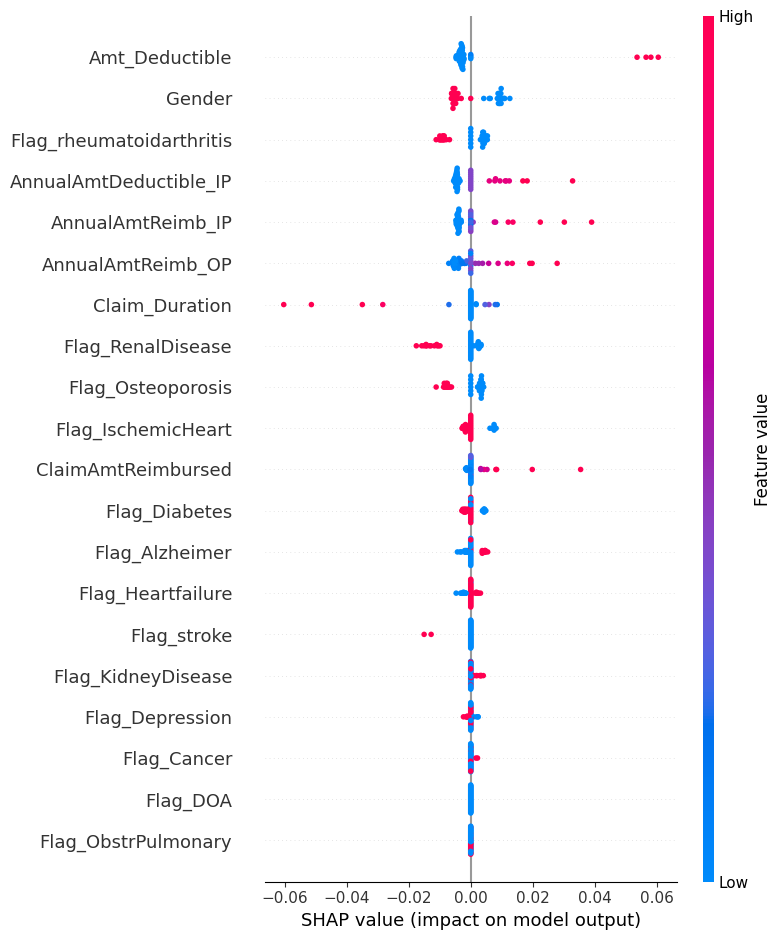

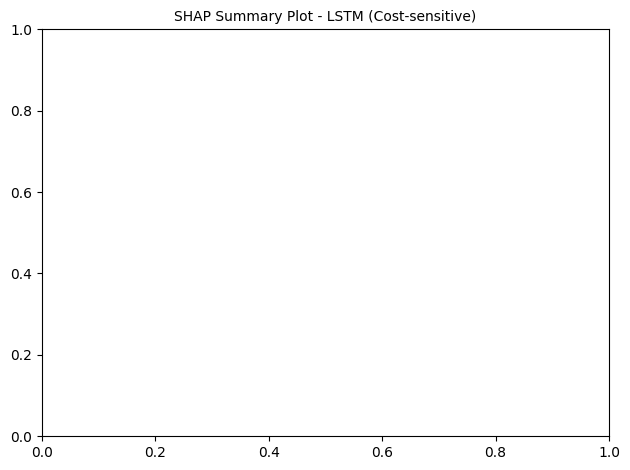

In [ ]:
#Plot SHAP summary
plt.figure(figsize=(6, 6))
shap.summary_plot(
    shap_values_lstm_cost,
    X_explain_lstm_cost_flat,
    feature_names=feature_names,
    plot_type="dot"
)
plt.title("SHAP Summary Plot - LSTM (Cost-sensitive)", fontsize=10)
plt.tight_layout()

ROC Curve for All LSTM Models

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(roc_lstm[0], roc_lstm[1], label='Baseline', linewidth=2)
plt.plot(roc_lstm_smote[0], roc_lstm_smote[1], label='SMOTE', linewidth=2)
plt.plot(roc_lstm_adas[0], roc_lstm_adas[1], label='ADASYN', linewidth=2)
plt.plot(roc_lstm_cost[0], roc_lstm_cost[1], label='Cost-sensitive', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for LSTM Models (Healthcare Fraud)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

Metrics Comparison Table for LSTM Models

In [ ]:
results_lstm_fraud = pd.DataFrame({
    "Method": ["Baseline", "SMOTE", "ADASYN", "Cost-sensitive"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_lstm_smote),
        accuracy_score(y_test, y_pred_lstm_adas),
        accuracy_score(y_test, y_pred_lstm_cost)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lstm),
        precision_score(y_test, y_pred_lstm_smote),
        precision_score(y_test, y_pred_lstm_adas),
        precision_score(y_test, y_pred_lstm_cost)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lstm),
        recall_score(y_test, y_pred_lstm_smote),
        recall_score(y_test, y_pred_lstm_adas),
        recall_score(y_test, y_pred_lstm_cost)
    ],
    "F1": [
        f1_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_lstm_smote),
        f1_score(y_test, y_pred_lstm_adas),
        f1_score(y_test, y_pred_lstm_cost)
    ],
    "AUC": [
        auc_lstm,
        auc_lstm_smote,
        auc_lstm_adas,
        auc_lstm_cost
    ]
})
print(results_lstm_fraud)

# Hybrid Model

CNN + LSTM BASELINE MODEL

In [ ]:
# Reshaping input
X_train_hybrid = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_hybrid  = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model
cnn_lstm_baseline = Sequential()

# Conv Block 1
cnn_lstm_baseline.add(Conv1D(32, 3, activation='relu', padding='same',
                             input_shape=(X_train_hybrid.shape[1], 1)))
cnn_lstm_baseline.add(BatchNormalization())
cnn_lstm_baseline.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_lstm_baseline.add(BatchNormalization())
cnn_lstm_baseline.add(MaxPooling1D(pool_size=2))
cnn_lstm_baseline.add(Dropout(0.3))

# Conv Block 2
cnn_lstm_baseline.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_baseline.add(BatchNormalization())
cnn_lstm_baseline.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_baseline.add(BatchNormalization())
cnn_lstm_baseline.add(MaxPooling1D(pool_size=2))
cnn_lstm_baseline.add(Dropout(0.3))

# LSTM stack
cnn_lstm_baseline.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_baseline.add(BatchNormalization())
cnn_lstm_baseline.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_baseline.add(BatchNormalization())

# Dense head
cnn_lstm_baseline.add(Dense(128, activation='relu'))
cnn_lstm_baseline.add(Dropout(0.4))
cnn_lstm_baseline.add(Dense(64, activation='relu'))
cnn_lstm_baseline.add(Dropout(0.3))
cnn_lstm_baseline.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_lstm_baseline.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                          metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Fitting model with early stopping
cnn_lstm_baseline.fit(
    X_train_hybrid,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluation
y_pred_probs_hybrid = cnn_lstm_baseline.predict(X_test_hybrid).flatten()
y_pred_hybrid = (y_pred_probs_hybrid > 0.5).astype(int)

In [ ]:
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
roc_hybrid = roc_curve(y_test, y_pred_probs_hybrid)
auc_hybrid = roc_auc_score(y_test, y_pred_probs_hybrid)

print("Confusion Matrix (CNN+LSTM Baseline):")
print(cm_hybrid)

CNN + LSTM + SMOTE

In [ ]:
X_train_smote_hybrid = X_train_smote.values.reshape((X_train_smote.shape[0], X_train_smote.shape[1], 1))


In [ ]:
# Defining Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Defining model
cnn_lstm_smote = Sequential()

# Conv Block 1
cnn_lstm_smote.add(Conv1D(32, 3, activation='relu', padding='same',
                          input_shape=(X_train_smote_hybrid.shape[1], 1)))
cnn_lstm_smote.add(BatchNormalization())
cnn_lstm_smote.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_lstm_smote.add(BatchNormalization())
cnn_lstm_smote.add(MaxPooling1D(pool_size=2))
cnn_lstm_smote.add(Dropout(0.3))

# Conv Block 2
cnn_lstm_smote.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_smote.add(BatchNormalization())
cnn_lstm_smote.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_smote.add(BatchNormalization())
cnn_lstm_smote.add(MaxPooling1D(pool_size=2))
cnn_lstm_smote.add(Dropout(0.3))

# LSTM stack
cnn_lstm_smote.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_smote.add(BatchNormalization())
cnn_lstm_smote.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_smote.add(BatchNormalization())

# Dense head
cnn_lstm_smote.add(Dense(128, activation='relu'))
cnn_lstm_smote.add(Dropout(0.4))
cnn_lstm_smote.add(Dense(64, activation='relu'))
cnn_lstm_smote.add(Dropout(0.3))
cnn_lstm_smote.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_lstm_smote.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Fitting model with early stopping
cnn_lstm_smote.fit(
    X_train_smote_hybrid,
    y_train_smote,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluation
y_pred_probs_hybrid_smote = cnn_lstm_smote.predict(X_test_hybrid).flatten()
y_pred_hybrid_smote = (y_pred_probs_hybrid_smote > 0.5).astype(int)

In [ ]:
cm_hybrid_smote = confusion_matrix(y_test, y_pred_hybrid_smote)
roc_hybrid_smote = roc_curve(y_test, y_pred_probs_hybrid_smote)
auc_hybrid_smote = roc_auc_score(y_test, y_pred_probs_hybrid_smote)

print("Confusion Matrix (SMOTE):")
print(cm_hybrid_smote)

CNN + LSTM + ADASYN

In [ ]:
X_train_adas_hybrid = X_train_adas.values.reshape((X_train_adas.shape[0], X_train_adas.shape[1], 1))


In [ ]:
# Defining EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# Defining model
cnn_lstm_adas = Sequential()

# Conv Block 1
cnn_lstm_adas.add(Conv1D(32, 3, activation='relu', padding='same',
                         input_shape=(X_train_adas_hybrid.shape[1], 1)))
cnn_lstm_adas.add(BatchNormalization())
cnn_lstm_adas.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_lstm_adas.add(BatchNormalization())
cnn_lstm_adas.add(MaxPooling1D(pool_size=2))
cnn_lstm_adas.add(Dropout(0.3))

# Conv Block 2
cnn_lstm_adas.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_adas.add(BatchNormalization())
cnn_lstm_adas.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_adas.add(BatchNormalization())
cnn_lstm_adas.add(MaxPooling1D(pool_size=2))
cnn_lstm_adas.add(Dropout(0.3))

# LSTM stack
cnn_lstm_adas.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_adas.add(BatchNormalization())
cnn_lstm_adas.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_adas.add(BatchNormalization())

# Dense head
cnn_lstm_adas.add(Dense(128, activation='relu'))
cnn_lstm_adas.add(Dropout(0.4))
cnn_lstm_adas.add(Dense(64, activation='relu'))
cnn_lstm_adas.add(Dropout(0.3))
cnn_lstm_adas.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_lstm_adas.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting model with early stopping
cnn_lstm_adas.fit(
    X_train_adas_hybrid,
    y_train_adas,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluation
y_pred_probs_hybrid_adas = cnn_lstm_adas.predict(X_test_hybrid).flatten()
y_pred_hybrid_adas = (y_pred_probs_hybrid_adas > 0.5).astype(int)

In [ ]:
cm_hybrid_adas = confusion_matrix(y_test, y_pred_hybrid_adas)
roc_hybrid_adas = roc_curve(y_test, y_pred_probs_hybrid_adas)
auc_hybrid_adas = roc_auc_score(y_test, y_pred_probs_hybrid_adas)

print("Confusion Matrix (ADASYN):")
print(cm_hybrid_adas)

Cost-sensitive CNN + LSTM

In [ ]:
# Defining EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# Defining model
cnn_lstm_cost = Sequential()

# Conv Block 1
cnn_lstm_cost.add(Conv1D(32, 3, activation='relu', padding='same',
                         input_shape=(X_train_hybrid.shape[1], 1)))
cnn_lstm_cost.add(BatchNormalization())
cnn_lstm_cost.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn_lstm_cost.add(BatchNormalization())
cnn_lstm_cost.add(MaxPooling1D(pool_size=2))
cnn_lstm_cost.add(Dropout(0.3))

# Conv Block 2
cnn_lstm_cost.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_cost.add(BatchNormalization())
cnn_lstm_cost.add(Conv1D(128, 3, activation='relu', padding='same'))
cnn_lstm_cost.add(BatchNormalization())
cnn_lstm_cost.add(MaxPooling1D(pool_size=2))
cnn_lstm_cost.add(Dropout(0.3))

# LSTM stack
cnn_lstm_cost.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_cost.add(BatchNormalization())
cnn_lstm_cost.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))
cnn_lstm_cost.add(BatchNormalization())

# Dense head
cnn_lstm_cost.add(Dense(128, activation='relu'))
cnn_lstm_cost.add(Dropout(0.4))
cnn_lstm_cost.add(Dense(64, activation='relu'))
cnn_lstm_cost.add(Dropout(0.3))
cnn_lstm_cost.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compiling model
cnn_lstm_cost.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Fitting with class weights + early stopping
cnn_lstm_cost.fit(
    X_train_hybrid,
    y_train,
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predicting & evaluation
y_pred_probs_hybrid_cost = cnn_lstm_cost.predict(X_test_hybrid).flatten()
y_pred_hybrid_cost = (y_pred_probs_hybrid_cost > 0.5).astype(int)

In [ ]:
cm_hybrid_cost = confusion_matrix(y_test, y_pred_hybrid_cost)
roc_hybrid_cost = roc_curve(y_test, y_pred_probs_hybrid_cost)
auc_hybrid_cost = roc_auc_score(y_test, y_pred_probs_hybrid_cost)

print("Confusion Matrix (Cost-sensitive):")
print(cm_hybrid_cost)

ROC Curve for All CNN+LSTM Models

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(roc_hybrid[0], roc_hybrid[1], label='Baseline', linewidth=2)
plt.plot(roc_hybrid_smote[0], roc_hybrid_smote[1], label='SMOTE', linewidth=2)
plt.plot(roc_hybrid_adas[0], roc_hybrid_adas[1], label='ADASYN', linewidth=2)
plt.plot(roc_hybrid_cost[0], roc_hybrid_cost[1], label='Cost-sensitive', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for CNN+LSTM Models (Healthcare Fraud)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

Metrics Comparison Table for CNN+LSTM Models

In [ ]:
results_cnn_lstm_fraud = pd.DataFrame({
    "Method": ["Baseline", "SMOTE", "ADASYN", "Cost-sensitive"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_hybrid),
        accuracy_score(y_test, y_pred_hybrid_smote),
        accuracy_score(y_test, y_pred_hybrid_adas),
        accuracy_score(y_test, y_pred_hybrid_cost)
    ],
    "Precision": [
        precision_score(y_test, y_pred_hybrid),
        precision_score(y_test, y_pred_hybrid_smote),
        precision_score(y_test, y_pred_hybrid_adas),
        precision_score(y_test, y_pred_hybrid_cost)
    ],
    "Recall": [
        recall_score(y_test, y_pred_hybrid),
        recall_score(y_test, y_pred_hybrid_smote),
        recall_score(y_test, y_pred_hybrid_adas),
        recall_score(y_test, y_pred_hybrid_cost)
    ],
    "F1": [
        f1_score(y_test, y_pred_hybrid),
        f1_score(y_test, y_pred_hybrid_smote),
        f1_score(y_test, y_pred_hybrid_adas),
        f1_score(y_test, y_pred_hybrid_cost)
    ],
    "AUC": [
        auc_hybrid,
        auc_hybrid_smote,
        auc_hybrid_adas,
        auc_hybrid_cost
    ]
})
print(results_cnn_lstm_fraud)